In [2]:
import functools
from collections import namedtuple
from pathlib import Path

import numpy as np

from scipy import signal

from astropy import units as u
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


# Data Loading

In [4]:
alltensorpaths = list(Path('resampled_tensors').glob('*_2k.pt'))
len(alltensorpaths)

7508

In [5]:
headers = []
wls = []
fluxes = []

for pth in tqdm(alltensorpaths):
    data = torch.load(pth, weights_only=True)
    headers.append(data['header'])
    wls.append(data['wl'])
    fluxes.append(data['flux'])

fluxes = torch.stack(fluxes)

  0%|          | 0/7508 [00:00<?, ?it/s]

In [6]:
assert torch.all(torch.stack(wls)==wls[0])
wl = wls[0]
del wls

In [7]:
teff = torch.tensor([h['PHXTEFF'] for h in headers])
logg = torch.tensor([h['PHXLOGG'] for h in headers])
feh = torch.tensor([h['PHXM_H'] for h in headers])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

Select a subset to experiment with

In [16]:
np.random.seed(44)
randidxs = np.random.permutation(fluxes.shape[0])[:6]


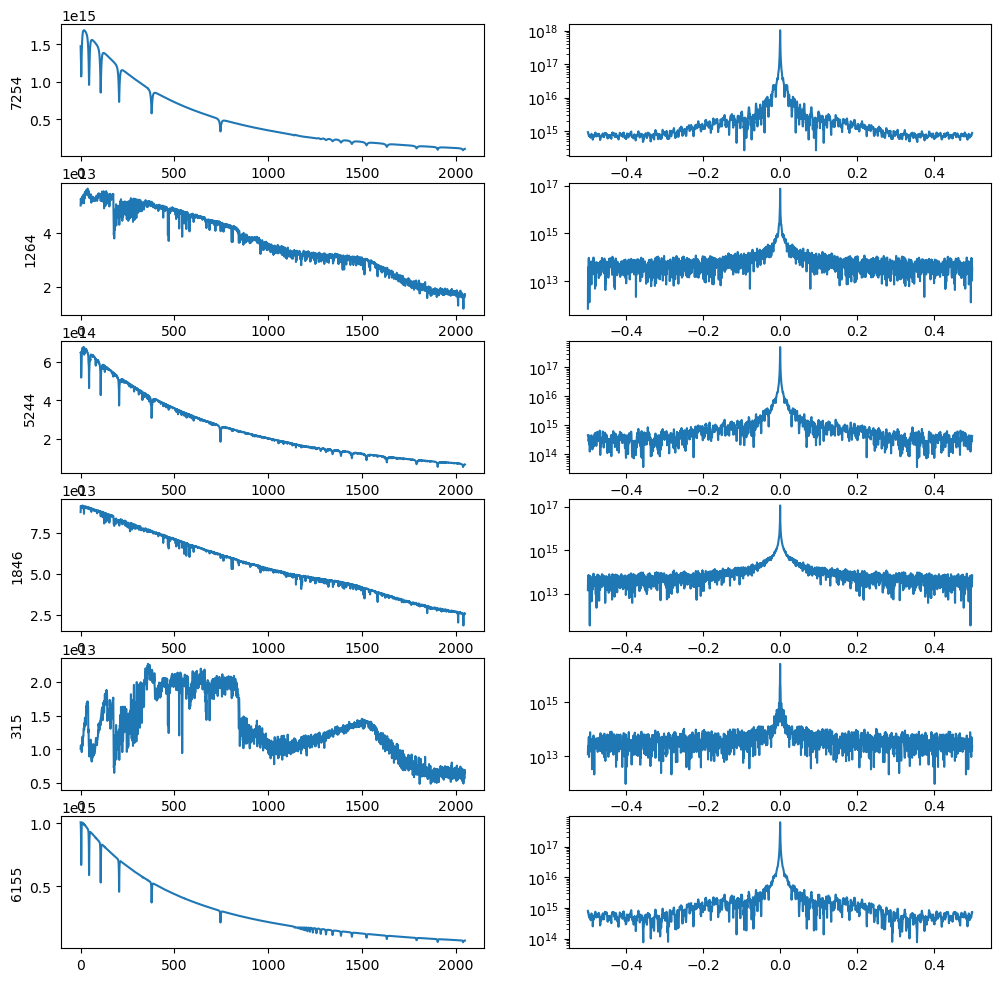

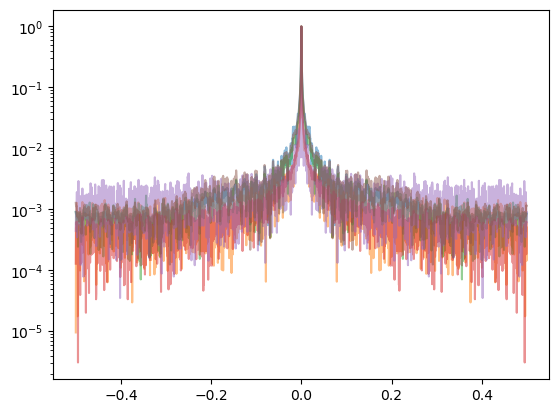

In [17]:
fftluxes = torch.fft.fft(fluxes, dim=-1)

f = torch.fft.fftshift(torch.fft.fftfreq(fftluxes.shape[1]))

ffts = []
fig, axs = plt.subplots(6,2, figsize=(12, 12))
for axrow, flux, fftlux, idx in zip(axs, fluxes[randidxs], fftluxes[randidxs], randidxs):
    ax1, ax2 = axrow
    ax1.plot(flux)
    ffts.append(torch.fft.fftshift(fftlux.abs()))
    ax2.plot(f, ffts[-1])
    ax2.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

# Filtering experiments on the above spectra

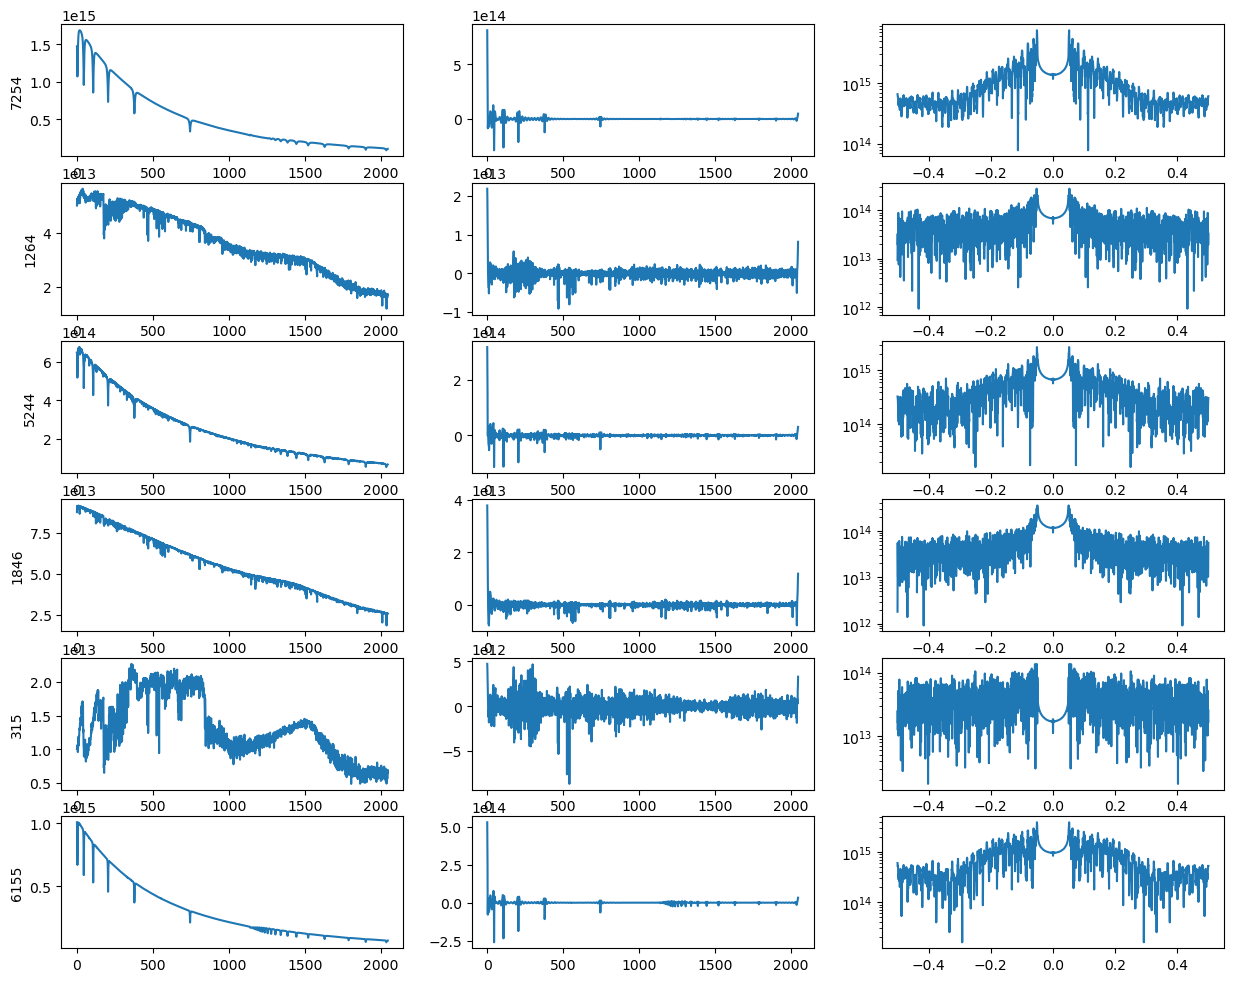

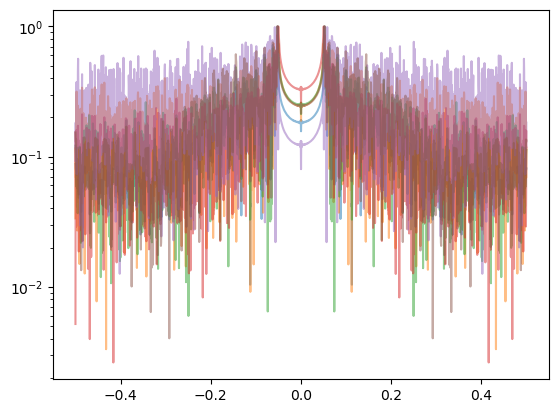

In [18]:
kernel = signal.firwin(1023, 0.1, pass_zero=False)
filtered_fluxes = [signal.convolve(flux, kernel, mode='same') for flux in fluxes[randidxs]]

# sosf = signal.iirdesign(wp=0.02, ws=0.01,gpass=1, gstop=40, output='sos')
# filtered_fluxes = [signal.sosfilt(sosf, (f-f.mean()).numpy()) for f in fluxes[randidxs]]

filtered_fftluxes = np.fft.fft(filtered_fluxes, axis=-1)

f = np.fft.fftshift(np.fft.fftfreq(filtered_fluxes[-1].size))

ffts = []
fig, axs = plt.subplots(6,3, figsize=(15, 12))
for axrow, flux, fflux, fftlux, idx in zip(axs, fluxes[randidxs], filtered_fluxes, filtered_fftluxes, randidxs):
    ax1, ax2, ax3 = axrow
    ax1.plot(flux)
    ax2.plot(fflux)
    ffts.append(np.fft.fftshift(np.abs(fftlux)))
    ax3.plot(f, ffts[-1])
    ax3.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

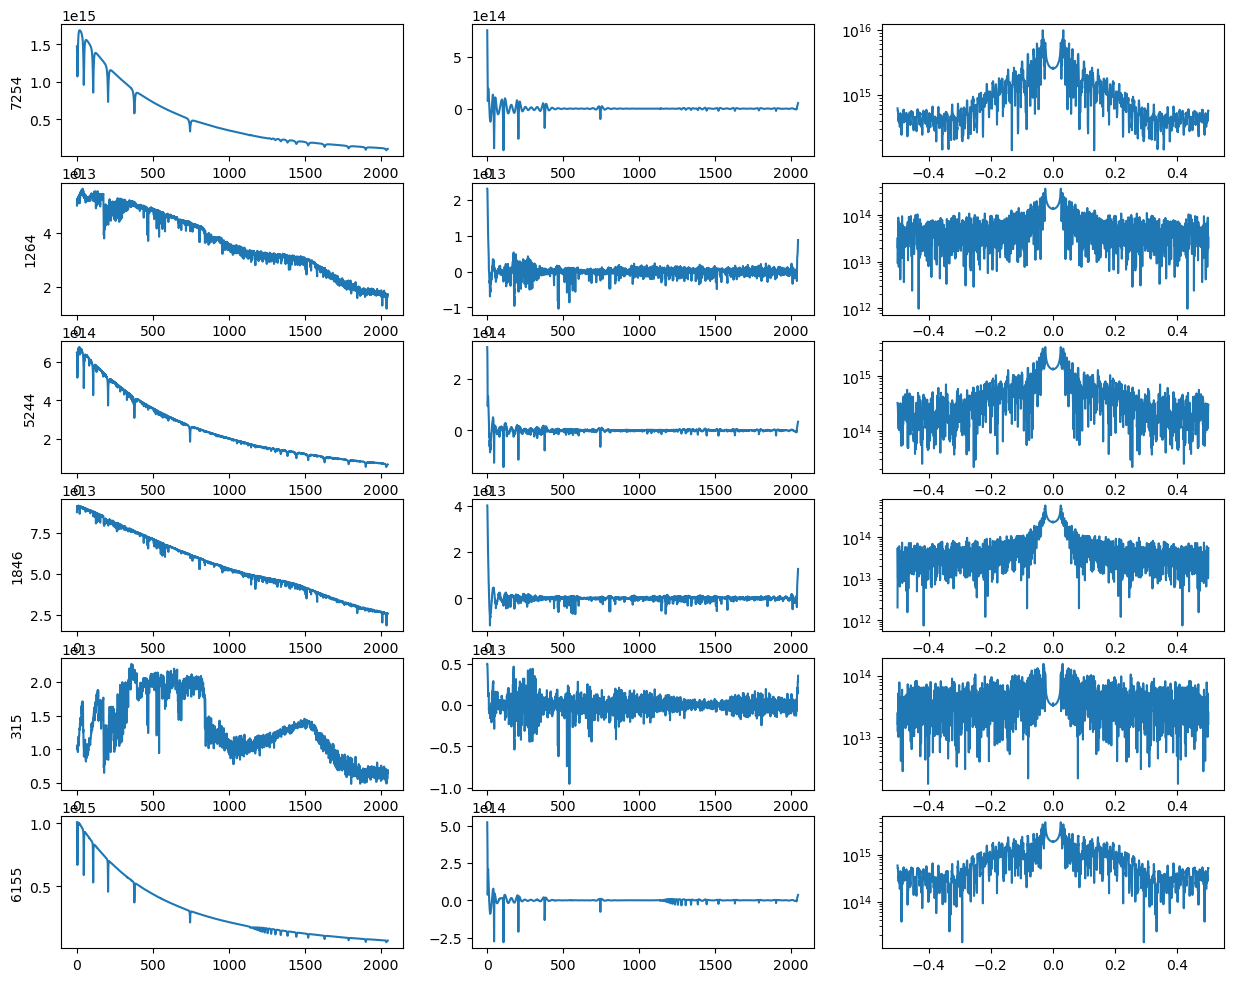

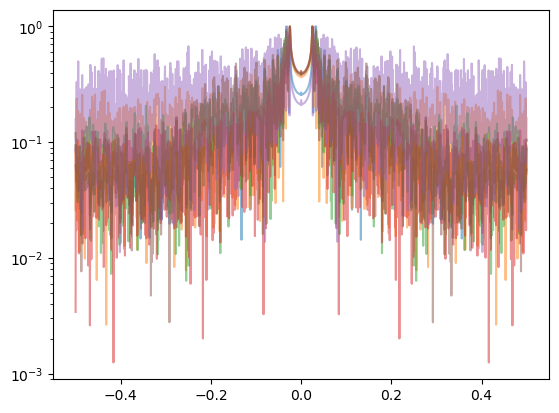

In [19]:
kernel = signal.firwin(1023, 0.05, pass_zero=False)
filtered_fluxes = [signal.convolve(flux, kernel, mode='same') for flux in fluxes[randidxs]]

# sosf = signal.iirdesign(wp=0.02, ws=0.01,gpass=1, gstop=40, output='sos')
# filtered_fluxes = [signal.sosfilt(sosf, (f-f.mean()).numpy()) for f in fluxes[randidxs]]

filtered_fftluxes = np.fft.fft(filtered_fluxes, axis=-1)

f = np.fft.fftshift(np.fft.fftfreq(filtered_fluxes[-1].size))

ffts = []
fig, axs = plt.subplots(6,3, figsize=(15, 12))
for axrow, flux, fflux, fftlux, idx in zip(axs, fluxes[randidxs], filtered_fluxes, filtered_fftluxes, randidxs):
    ax1, ax2, ax3 = axrow
    ax1.plot(flux)
    ax2.plot(fflux)
    ffts.append(np.fft.fftshift(np.abs(fftlux)))
    ax3.plot(f, ffts[-1])
    ax3.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

More traditional polynomial-fitting

 [astropy.modeling.fitting]


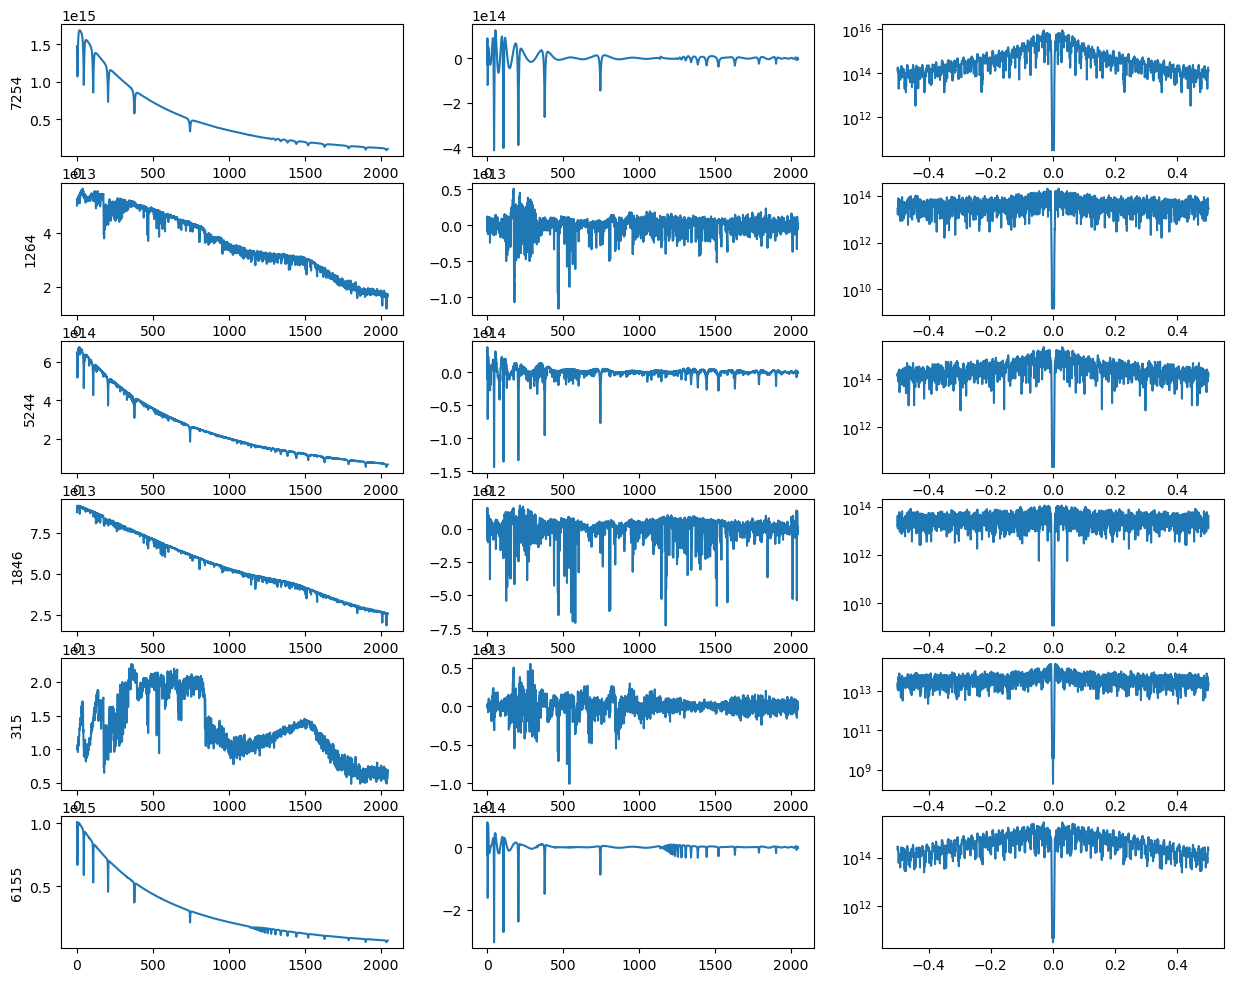

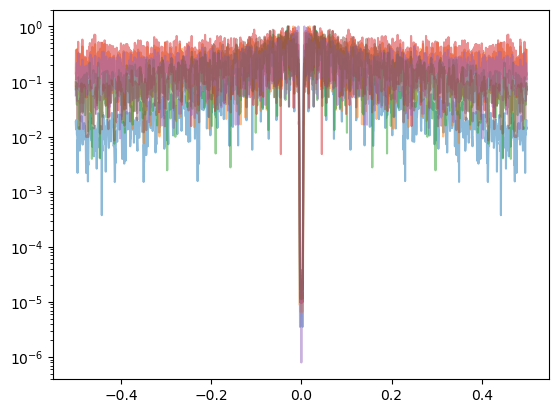

In [20]:
filtered_fluxes = []
for fluxt in fluxes[randidxs]:
    flux = fluxt.numpy()
    model0 = models.Polynomial1D(80)
    x = np.linspace(-1, 1, flux.shape[0])
    continuum = fitting.LinearLSQFitter()(model0, x, flux)
    filtered_fluxes.append(flux-continuum(x))

filtered_fftluxes = np.fft.fft(filtered_fluxes, axis=-1)

f = np.fft.fftshift(np.fft.fftfreq(filtered_fluxes[-1].size))

ffts = []
fig, axs = plt.subplots(6,3, figsize=(15, 12))
for axrow, flux, fflux, fftlux, idx in zip(axs, fluxes[randidxs], filtered_fluxes, filtered_fftluxes, randidxs):
    ax1, ax2, ax3 = axrow
    ax1.plot(flux)
    ax2.plot(fflux)
    ffts.append(np.fft.fftshift(np.abs(fftlux)))
    ax3.plot(f, ffts[-1])
    ax3.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

And how does that compare to BB-fitting?

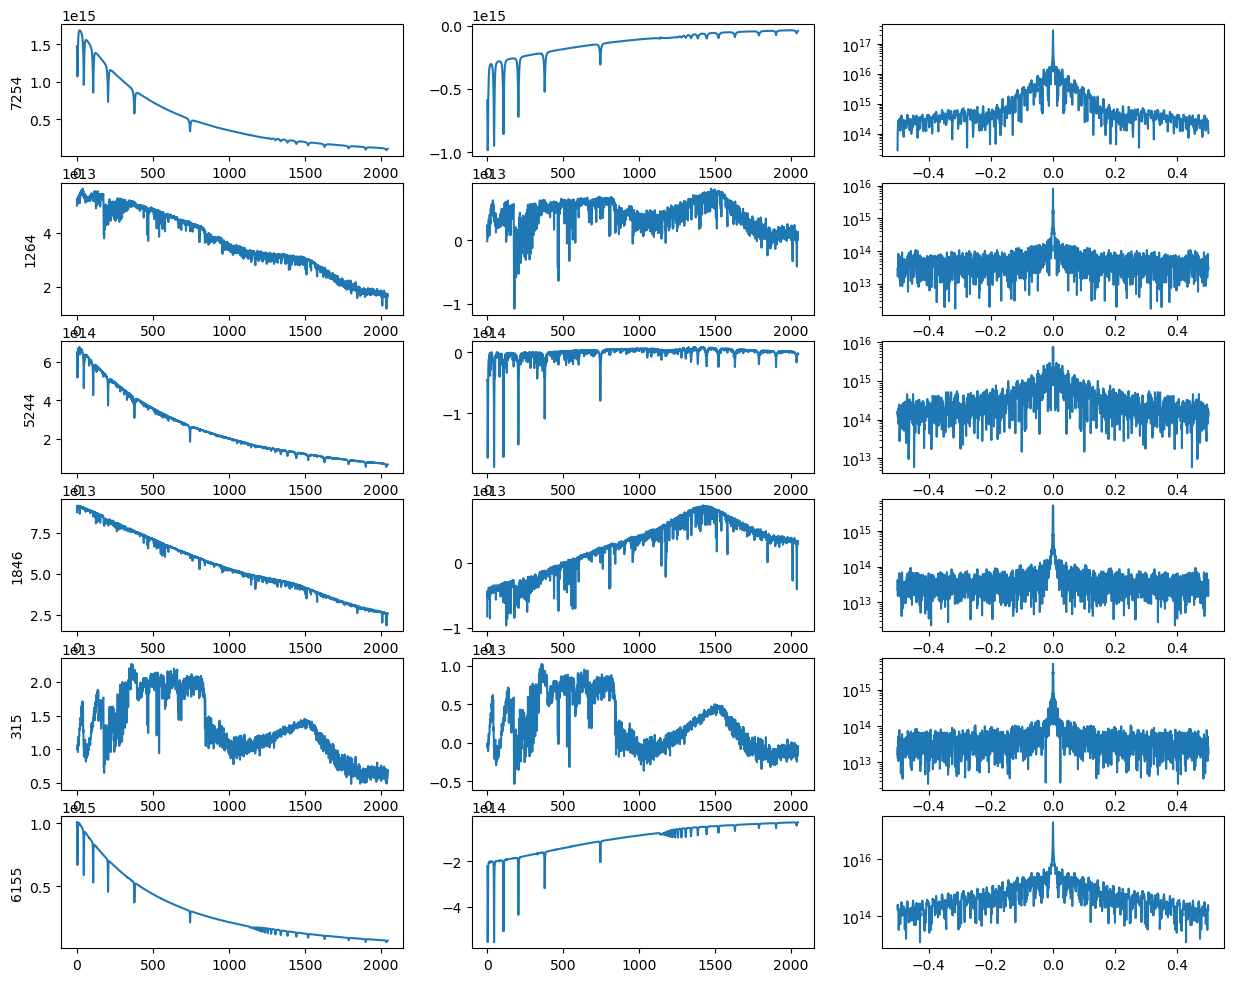

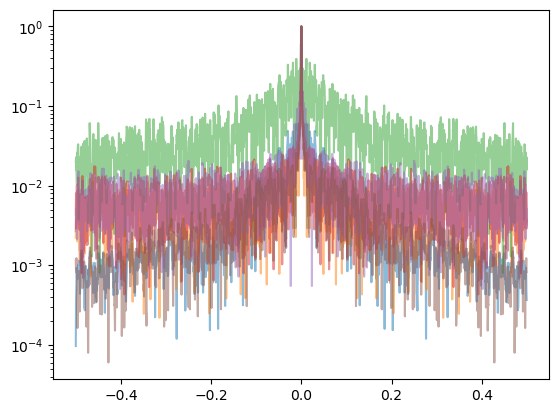

In [21]:
filtered_fluxes = []
for fluxt, teff in zip(fluxes[randidxs], infeatures[randidxs, 0]):
    flux = fluxt.numpy()
    bb = models.BlackBody(teff*u.K, scale=1*u.erg/u.s * u.cm**-2 / u.cm/u.sr)
    continuum = bb
    filtered_fluxes.append(flux-(continuum(wl)*np.pi*u.sr).value)

filtered_fftluxes = np.fft.fft(filtered_fluxes, axis=-1)

f = np.fft.fftshift(np.fft.fftfreq(filtered_fluxes[-1].size))

ffts = []
fig, axs = plt.subplots(6,3, figsize=(15, 12))
for axrow, flux, fflux, fftlux, idx in zip(axs, fluxes[randidxs], filtered_fluxes, filtered_fftluxes, randidxs):
    ax1, ax2, ax3 = axrow
    ax1.plot(flux)
    ax2.plot(fflux)
    ffts.append(np.fft.fftshift(np.abs(fftlux)))
    ax3.plot(f, ffts[-1])
    ax3.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

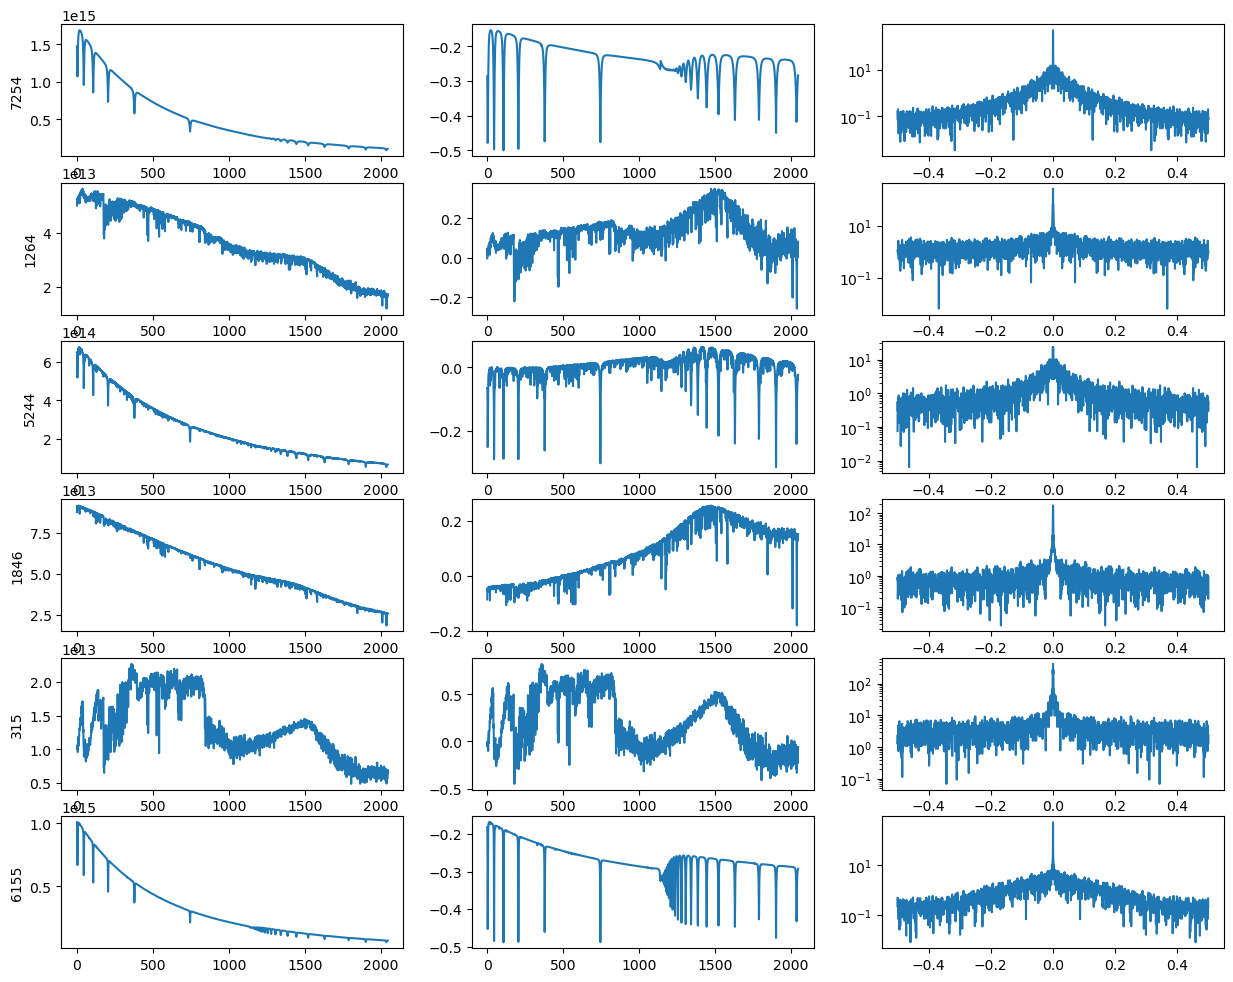

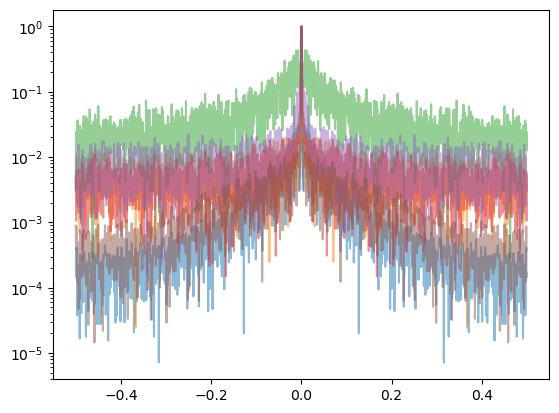

In [22]:
filtered_fluxes = []
for fluxt, teff in zip(fluxes[randidxs], infeatures[randidxs, 0]):
    flux = fluxt.numpy()
    bb = models.BlackBody(teff*u.K, scale=1*u.erg/u.s * u.cm**-2 / u.cm/u.sr)
    continuum = bb
    filtered_fluxes.append(flux/(continuum(wl)*np.pi*u.sr).value - 1)

filtered_fftluxes = np.fft.fft(filtered_fluxes, axis=-1)

f = np.fft.fftshift(np.fft.fftfreq(filtered_fluxes[-1].size))

ffts = []
fig, axs = plt.subplots(6,3, figsize=(15, 12))
for axrow, flux, fflux, fftlux, idx in zip(axs, fluxes[randidxs], filtered_fluxes, filtered_fftluxes, randidxs):
    ax1, ax2, ax3 = axrow
    ax1.plot(flux)
    ax2.plot(fflux)
    ffts.append(np.fft.fftshift(np.abs(fftlux)))
    ax3.plot(f, ffts[-1])
    ax3.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

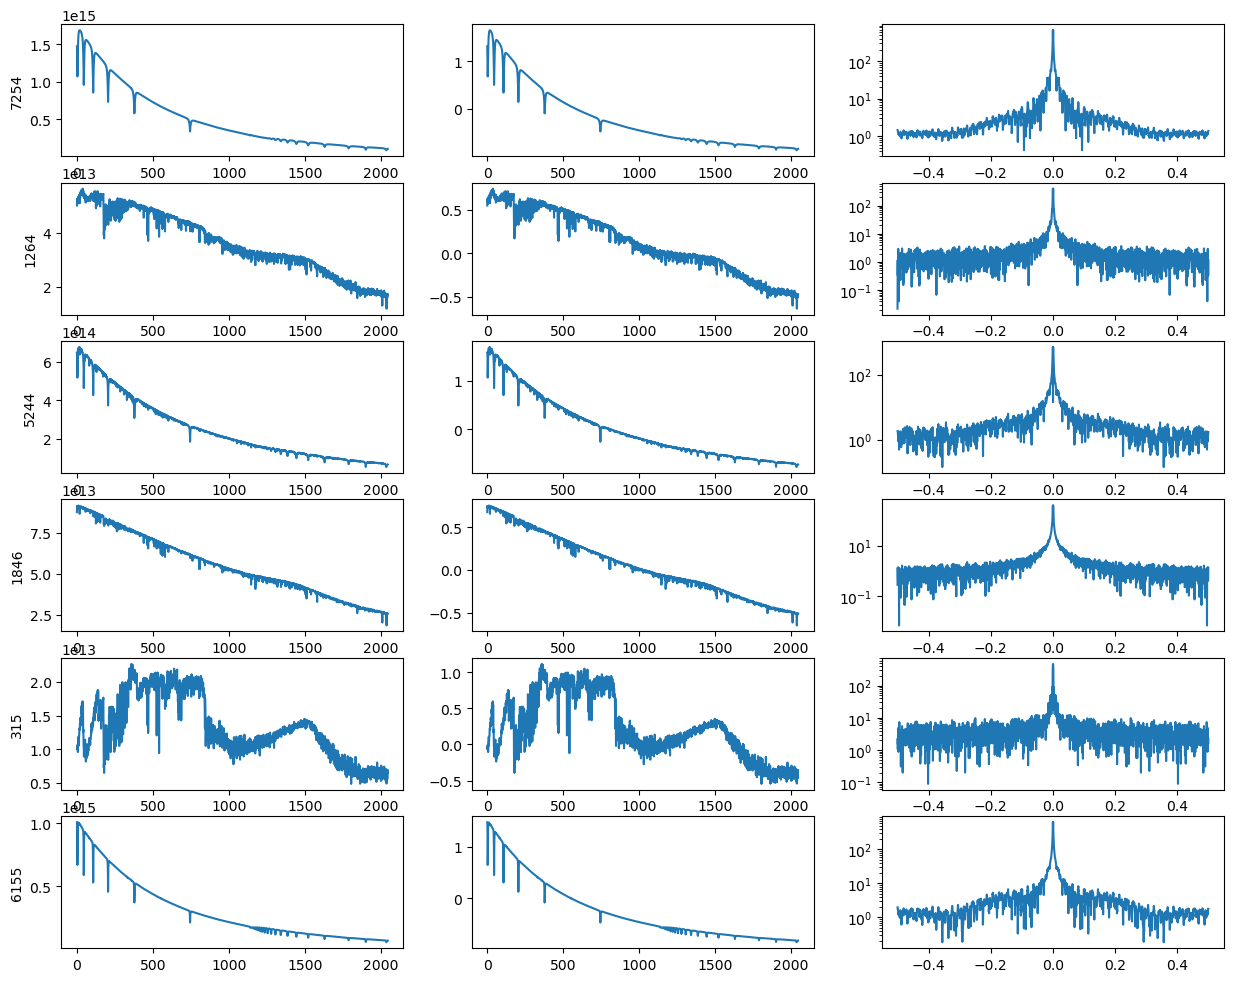

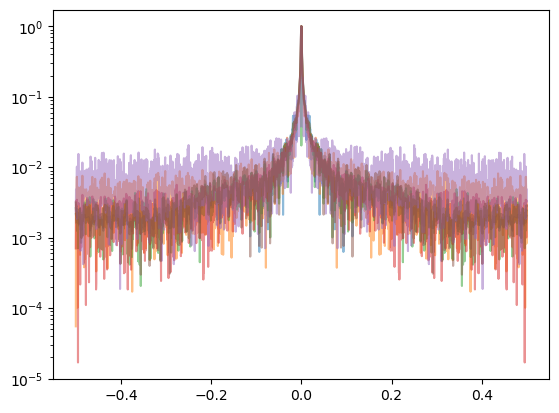

In [23]:
filtered_fluxes = []
for fluxt, teff in zip(fluxes[randidxs], infeatures[randidxs, 0]):
    flux = fluxt.numpy()
    bb = models.BlackBody(teff*u.K, scale=1*u.erg/u.s * u.cm**-2 / u.cm/u.sr)
    continuum = (bb(wl)*np.pi*u.sr).mean().value
    filtered_fluxes.append(flux/continuum - 1)

filtered_fftluxes = np.fft.fft(filtered_fluxes, axis=-1)

f = np.fft.fftshift(np.fft.fftfreq(filtered_fluxes[-1].size))

ffts = []
fig, axs = plt.subplots(6,3, figsize=(15, 12))
for axrow, flux, fflux, fftlux, idx in zip(axs, fluxes[randidxs], filtered_fluxes, filtered_fftluxes, randidxs):
    ax1, ax2, ax3 = axrow
    ax1.plot(flux)
    ax2.plot(fflux)
    ffts.append(np.fft.fftshift(np.abs(fftlux)))
    ax3.plot(f, ffts[-1])
    ax3.semilogy()
    ax1.set_ylabel(f'{idx}')

plt.figure()
plt.semilogy(f, np.array(ffts).T / np.max(ffts, axis=1), alpha=.5);

None of the filters seem to work as well as the standard continuum subtraction.  But maybe we still can use some of this for a loss function?

# Autoencoder with loss function that includes a fourier comparison

The autoencoder and related scaling is from [rescaling_experiments.ipynb](rescaling_experiments.ipynb), the "Simple BB normalization"

In [29]:
bbfluxes = []
for hdr in tqdm(headers):
    bb = models.BlackBody(temperature=hdr['PHXTEFF']*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wl << u.angstrom)*(np.pi*u.sr)
    bbfluxes.append(flux.to(u.erg/u.s * u.cm**-3).value)
bbfluxes = torch.from_numpy(np.array(bbfluxes))

bbmean = bbfluxes.mean(axis=-1)

bbsimplescale = fluxes/bbmean[...,None] - 1

  0%|          | 0/7508 [00:00<?, ?it/s]

In [30]:
class Encoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls):
        super().__init__()

        prev_layern = npix
        stack = []
        for nneur in nneurons:
            stack.append(nn.Linear(prev_layern, nneur))
            stack.append(activation_cls())
            prev_layern = nneur
            
        self.stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.stack[0].num_features
        
    @property
    def latent_size(self):
        return self.stack[-1].num_features
        
    def forward(self, x):
        return self.stack(x)

class Decoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls):
        super().__init__()

        prev_layern = nneurons[0]
        stack = []
        for nneur in nneurons[1:]:
            stack.append(nn.Linear(prev_layern, nneur))
            stack.append(activation_cls())
            prev_layern = nneur
        stack.append(nn.Linear(prev_layern, npix))
            
        self.stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.stack[-1].num_features
        
    @property
    def latent_size(self):
        return self.stack[0].num_features
        
    def forward(self, x):
        return self.stack(x)
        
class Autoencoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls=nn.GELU):
        super().__init__()

        self.encoder = Encoder(npix, nneurons, activation_cls)
        self.decoder = Decoder(npix, nneurons[::-1], activation_cls)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.encoder.stack[0].num_features
        
    @property
    def latent_size(self):
        return self.encoder.stack[-1].num_features
        
    def forward(self, x):
        x = torch.atleast_2d(x)
        latent = self.encoder(x)
        return self.decoder(latent)

aec = Autoencoder(fluxes.shape[-1], [100, 10])
aec

Autoencoder(
  (encoder): Encoder(
    (stack): Sequential(
      (0): Linear(in_features=2048, out_features=100, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=100, out_features=10, bias=True)
      (3): GELU(approximate='none')
    )
  )
  (decoder): Decoder(
    (stack): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=100, out_features=2048, bias=True)
    )
  )
)

In [31]:
def train_validation(model, dataset, nepochs, batch_size, lr, ttsplit=[.3, .7], inner_validation=False, weight_decay=0, eps=1e-8, loss_fcn=nn.MSELoss(), scheduler_fcn=None):
    split_data = random_split(dataset, ttsplit, torch.Generator().manual_seed(42))
    valid_data, train_data = split_data
    valid_X, valid_Y = valid_data.dataset.tensors[:2]
    
    valid_losses = []
    valid_niters = []

    train_losses = []
    train_niters = []

    lrs = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, eps=eps)
    if scheduler_fcn is not None:
        scheduler = scheduler_fcn(optimizer)
    
    niters = 0

    def validation_fcn():
        model.eval()
        with torch.no_grad():
            pred = model(valid_X)
            valid_loss = loss_fcn(pred,valid_Y).item()
            valid_losses.append(valid_loss)
            valid_niters.append(niters)
        return valid_loss
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for data in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            X, Y = data[:2]
            optimizer.zero_grad()
            
            pred = model(X)
            loss = loss_fcn(pred, Y)
            
            loss.backward()
            optimizer.step()
    
            niters += X.shape[0]
            
            train_losses.append(loss.item())
            train_niters.append(niters)

            if inner_validation:
                valid_loss = validation_fcn()
                
                if scheduler_fcn is not None:
                    scheduler.step()
                    lrs.append(scheduler.get_last_lr())
            
        if not inner_validation:
            if scheduler_fcn is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
                
            valid_loss = validation_fcn()
                
        if scheduler_fcn is None:
            pbar.set_description(f'valid loss={valid_loss:.3e}')
        else:
            pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')
            
    if scheduler_fcn is None:
        return (valid_niters, valid_losses), (train_niters, train_losses), split_data
    else:
        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data

In [32]:
def plot_sample_specs(model, data_split, descaler=None):
    valid_data, train_data = data_split
    valid_idxs = np.random.randint(len(valid_data), size=5)

    figs = []
    for valid_idx in valid_idxs:
        Xi, Yi, infeaturesi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
        
        pred = model(Xi[None,...])[0].detach()

        if descaler is not None:
            pred = descaler(pred, infeaturesi)
            Yi = fluxes[np.array(valid_data.indices[valid_idx])]
            
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        figs.append(fig)
        ax1, ax2 = axs
        
        ax1.plot(wl, Yi.cpu(), lw=1, label='true')
        ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
        ax1.legend(loc=0)
        ax1.set_title(f'{valid_idx}')
        
        msk = (14000<wl)&(wl<15000)
        ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
        ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
        ax2.legend(loc=0)
        ax2.set_title(f'{valid_idx} - zoom')
        
    return valid_idxs, figs

In [33]:
nneurons = 2048//(2**np.arange(7)[1:])

nperrestart = 4000
nrestarts = 3
lr = 1e-4
wd = 1e-4

nneurons

array([1024,  512,  256,  128,   64,   32])

First a baseline with no extra loss

  0%|          | 0/12000 [00:00<?, ?it/s]

(array([  28,  783, 1434,  978, 1509]),
 [<Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>])

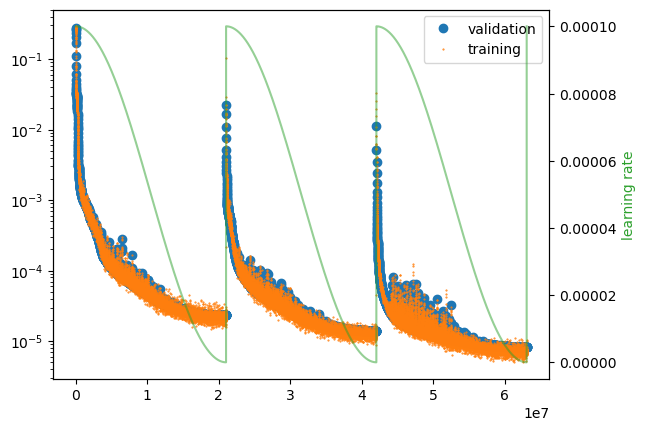

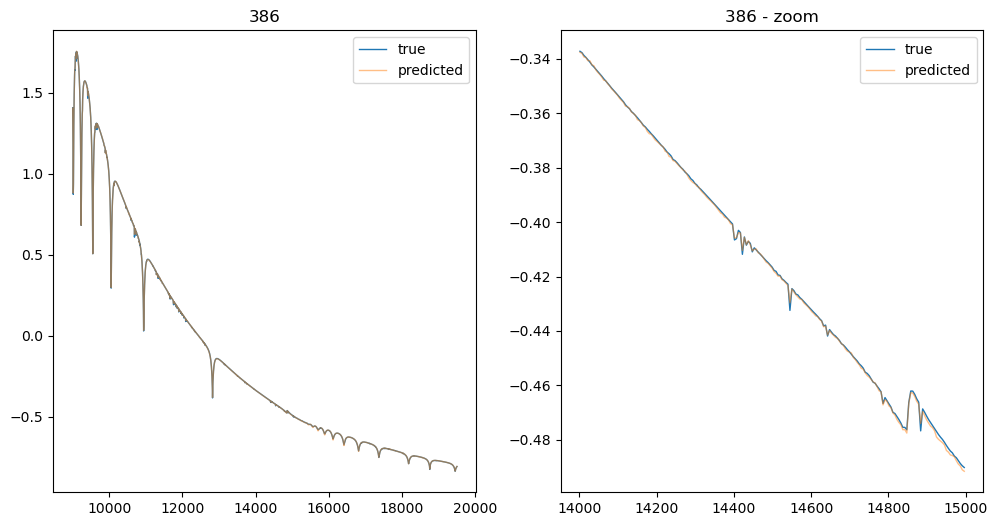

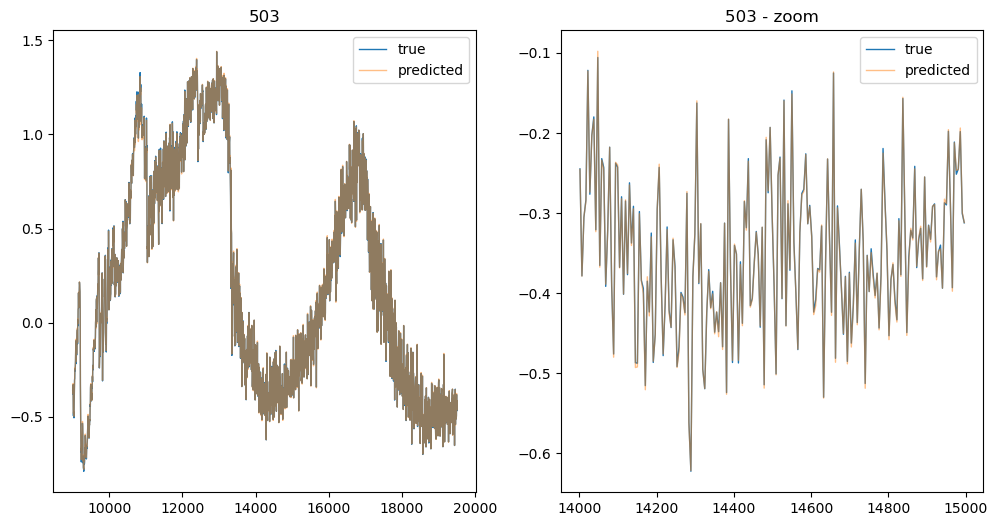

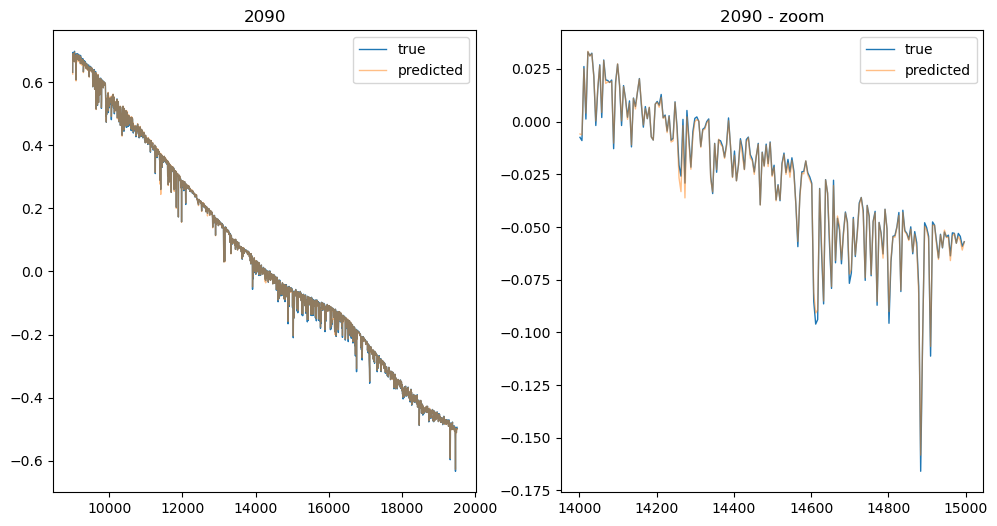

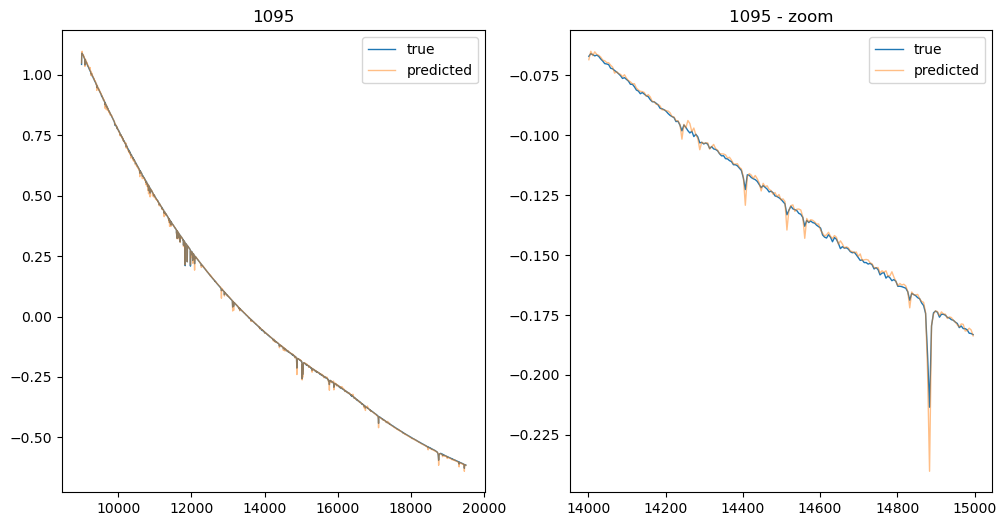

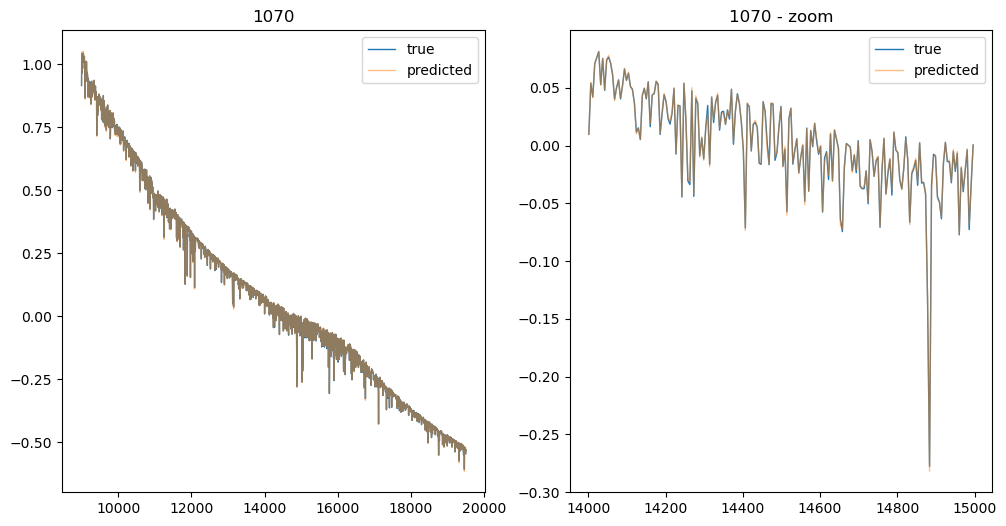

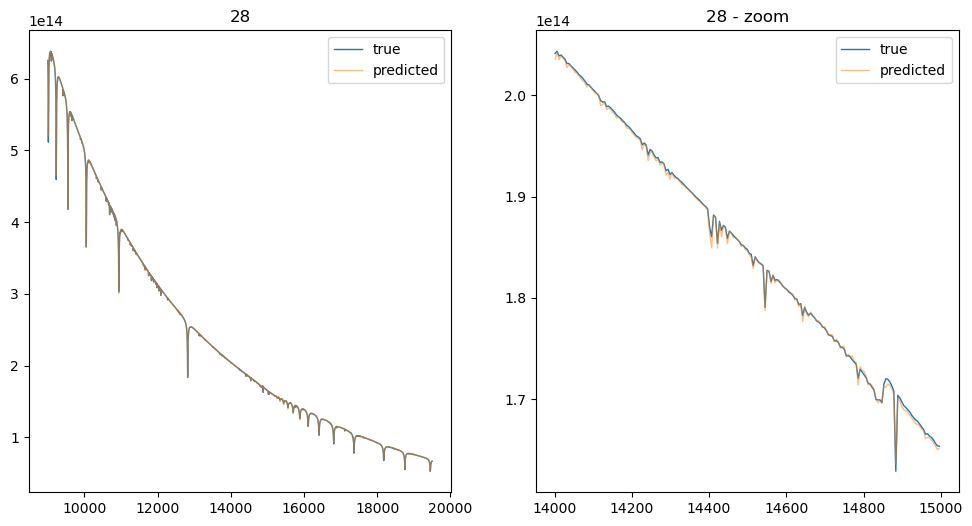

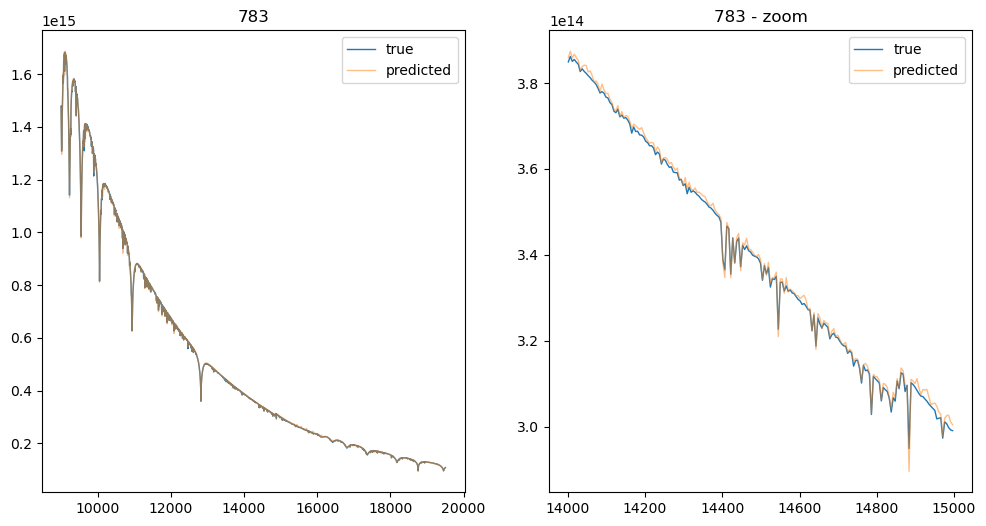

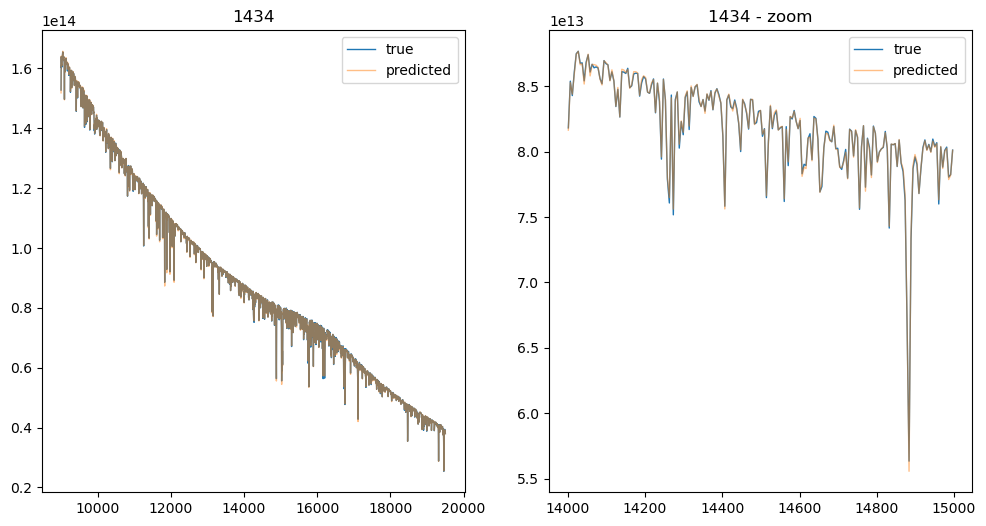

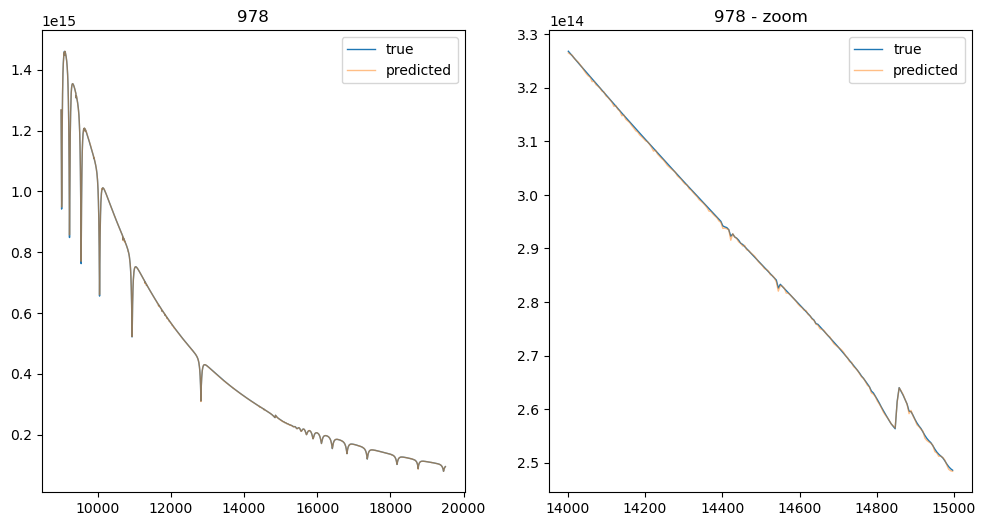

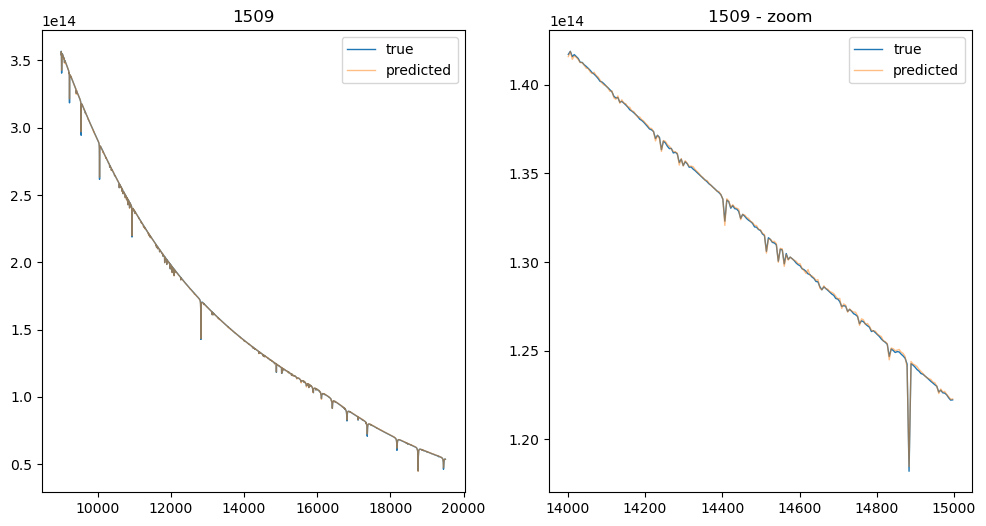

In [47]:
model = Autoencoder(fluxes.shape[-1], nneurons).to(device, tensor_dtype)

ds = TensorDataset(bbsimplescale.to(device, tensor_dtype), bbsimplescale.to(device, tensor_dtype), infeatures.to(device, tensor_dtype))

nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=lr, 
                                            weight_decay=wd, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')

plot_sample_specs(model, data_split)

def descaler(y, infeatures):
    bb = models.BlackBody(temperature=infeatures[0].item()*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    bbflux = (bb(wl << u.angstrom)*(np.pi*u.sr)).to(u.erg/u.s * u.cm**-3).value
    return (y + 1)*bbflux.mean() 
    
plot_sample_specs(model, data_split, descaler)

Loss in the fft only

  0%|          | 0/12000 [00:00<?, ?it/s]

(array([1779, 2176, 1306, 1962,  250]),
 [<Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>])

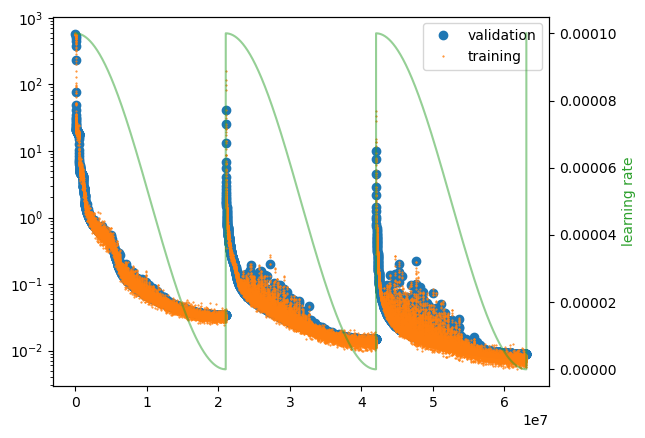

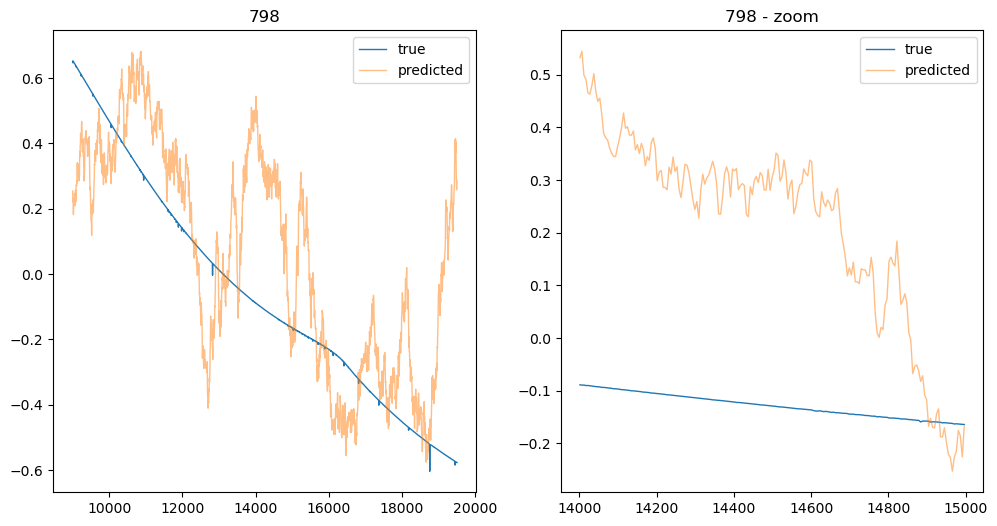

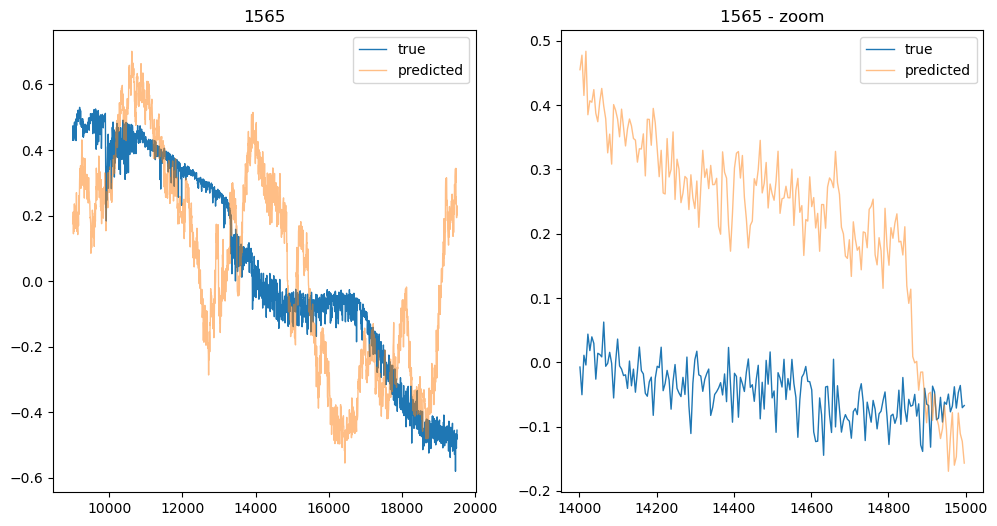

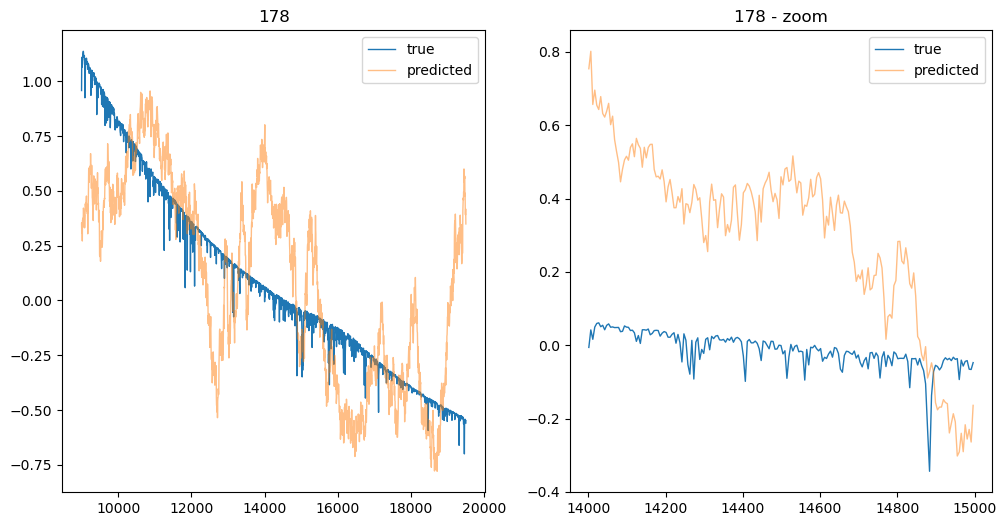

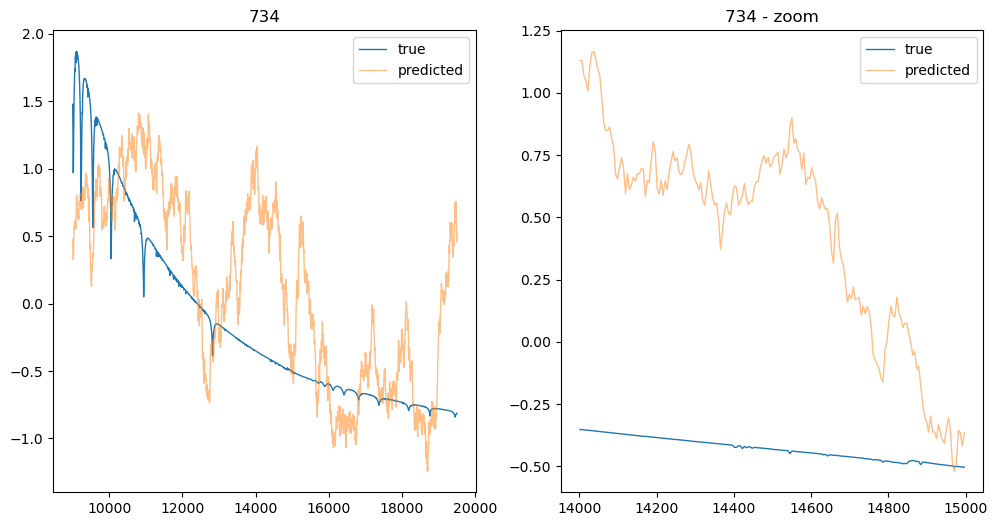

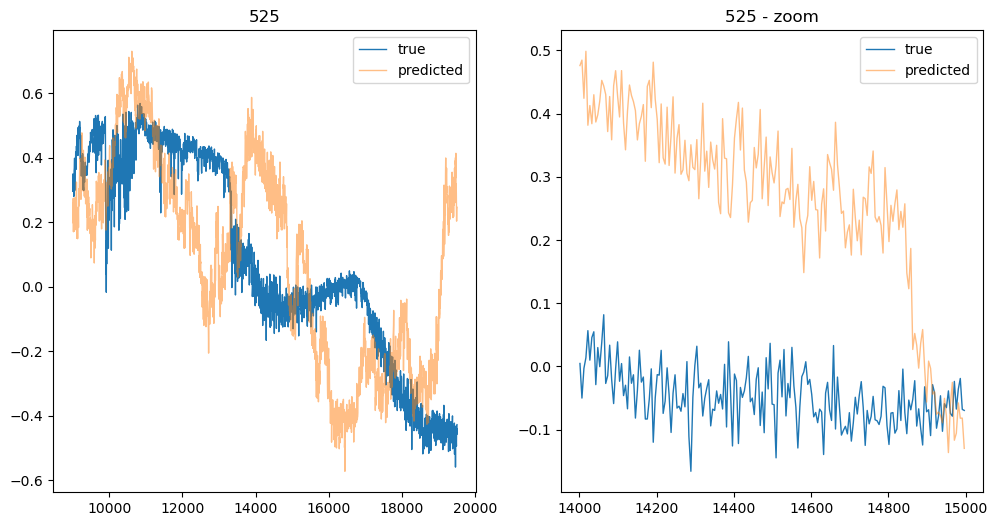

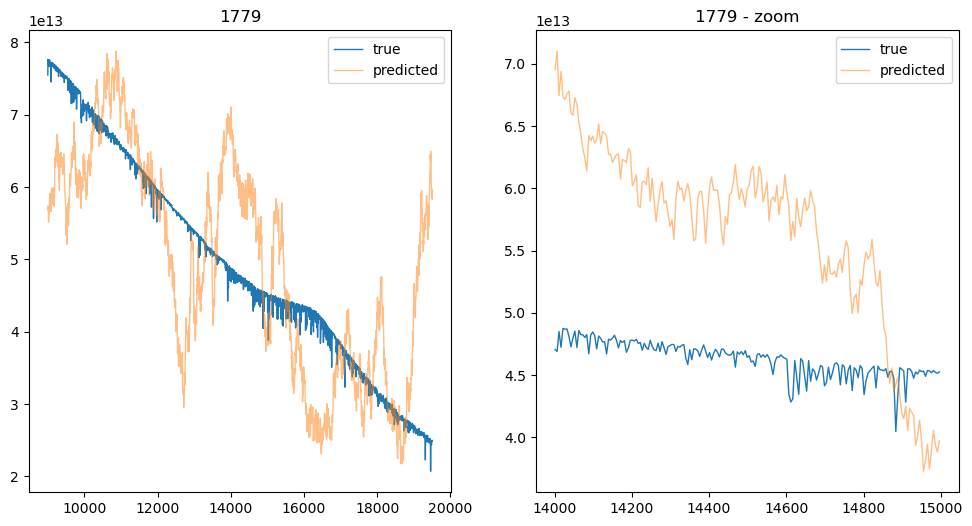

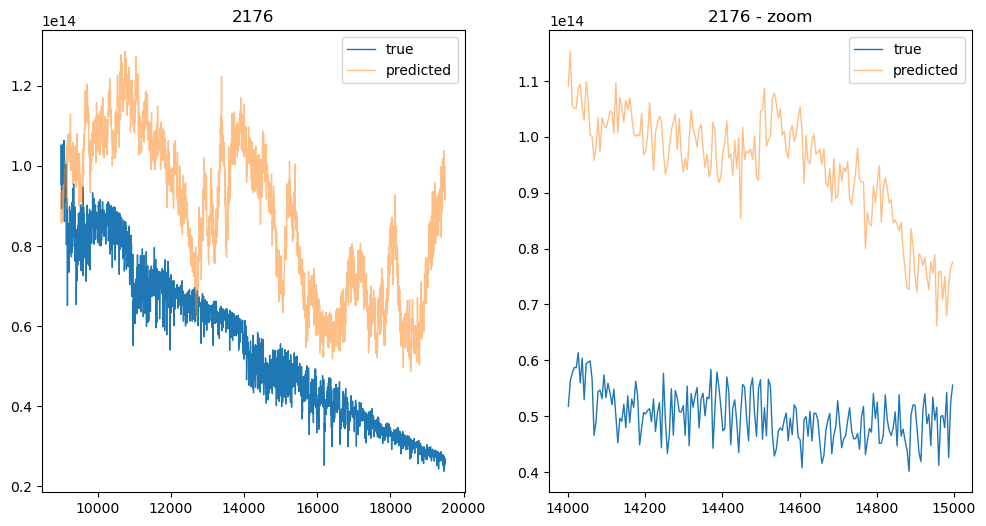

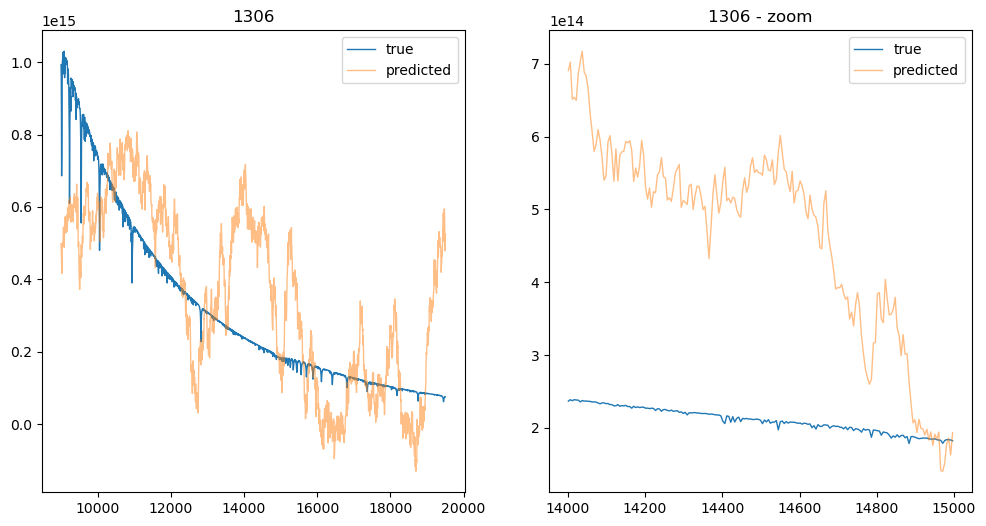

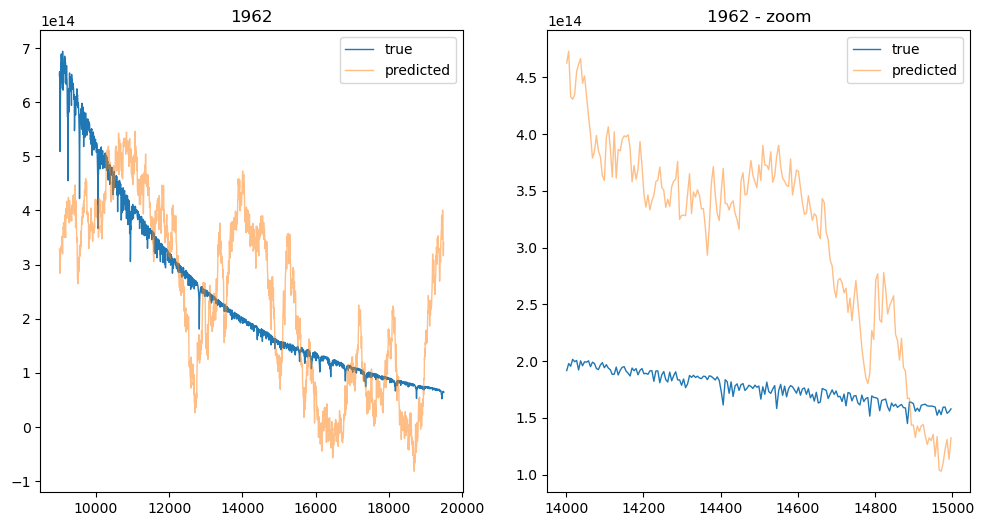

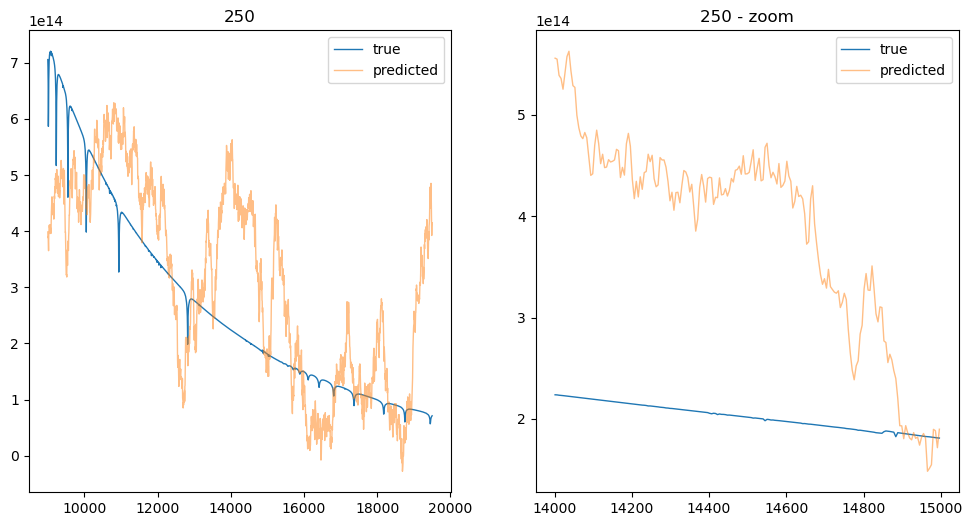

In [48]:
model = Autoencoder(fluxes.shape[-1], nneurons).to(device, tensor_dtype)

ds = TensorDataset(bbsimplescale.to(device, tensor_dtype), bbsimplescale.to(device, tensor_dtype), infeatures.to(device, tensor_dtype))

fourierloss = nn.MSELoss()
def msefft_loss(pred, y):
    Fpred = torch.fft.fft(pred)
    Fy = torch.fft.fft(y)
    return fourierloss(Fpred.abs(), Fy.abs())

nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=lr, 
                                            weight_decay=wd, 
                                            loss_fcn=msefft_loss, 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')

plot_sample_specs(model, data_split)

def descaler(y, infeatures):
    bb = models.BlackBody(temperature=infeatures[0].item()*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    bbflux = (bb(wl << u.angstrom)*(np.pi*u.sr)).to(u.erg/u.s * u.cm**-3).value
    return (y + 1)*bbflux.mean() 
    
plot_sample_specs(model, data_split, descaler)

Now try a combined version with the simplest possible approach: combine the regular and ft losses with a weighting factor

  0%|          | 0/12000 [00:00<?, ?it/s]

(array([ 893, 1829, 1326, 2221,  395]),
 [<Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>,
  <Figure size 1200x600 with 2 Axes>])

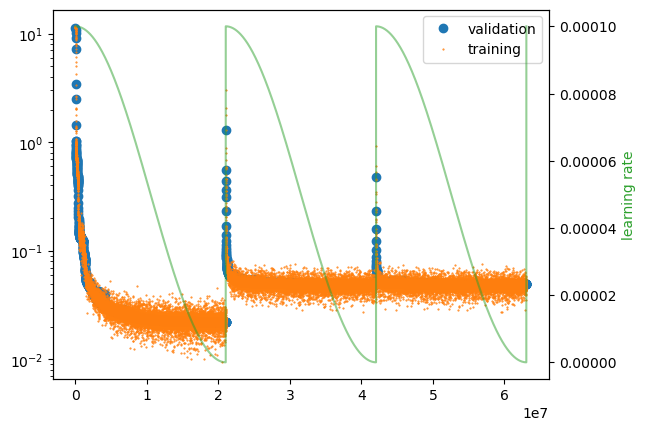

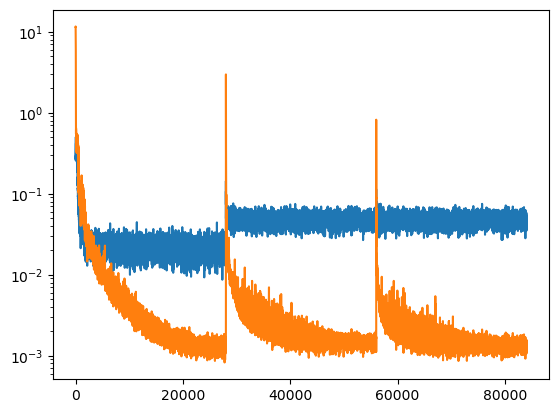

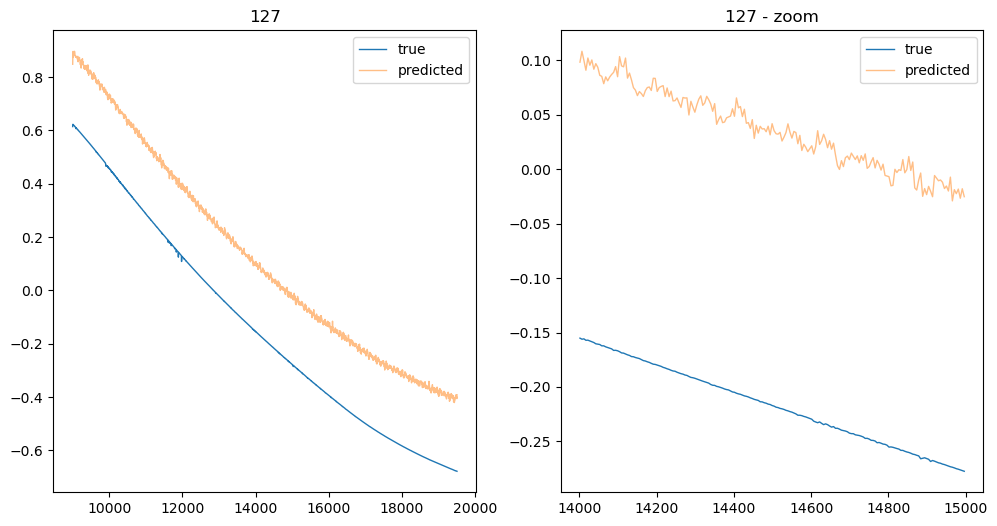

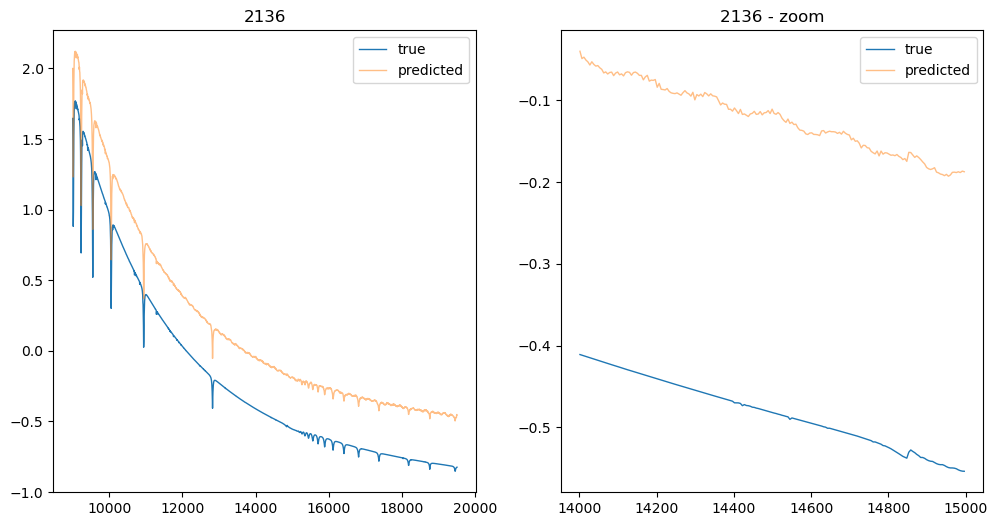

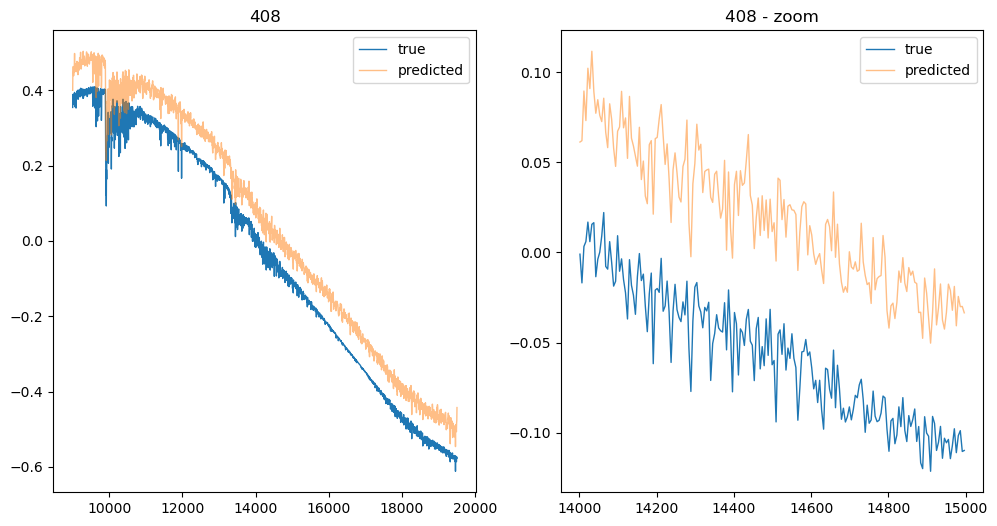

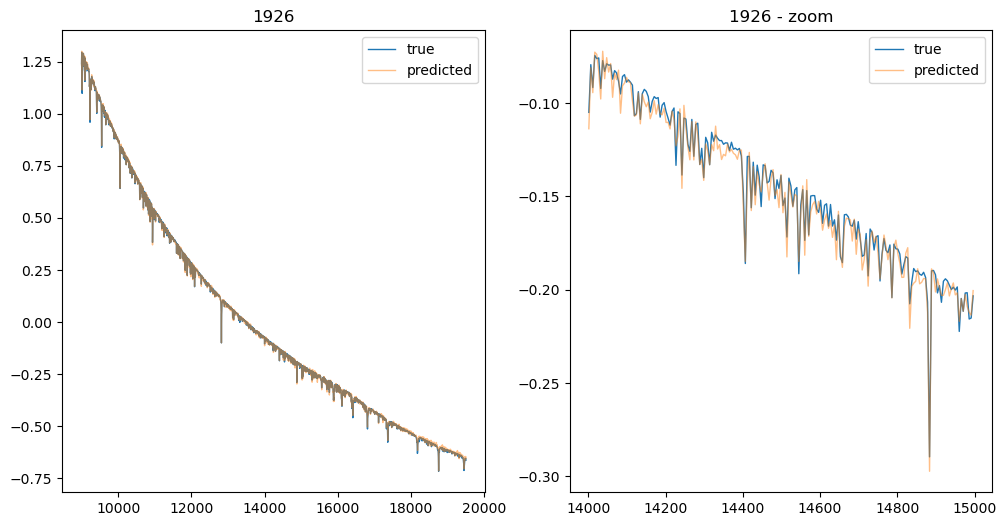

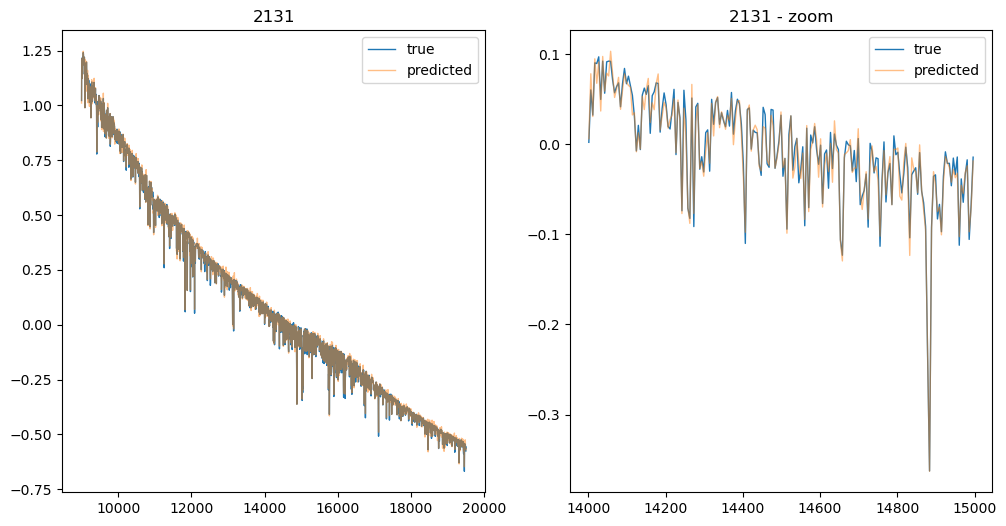

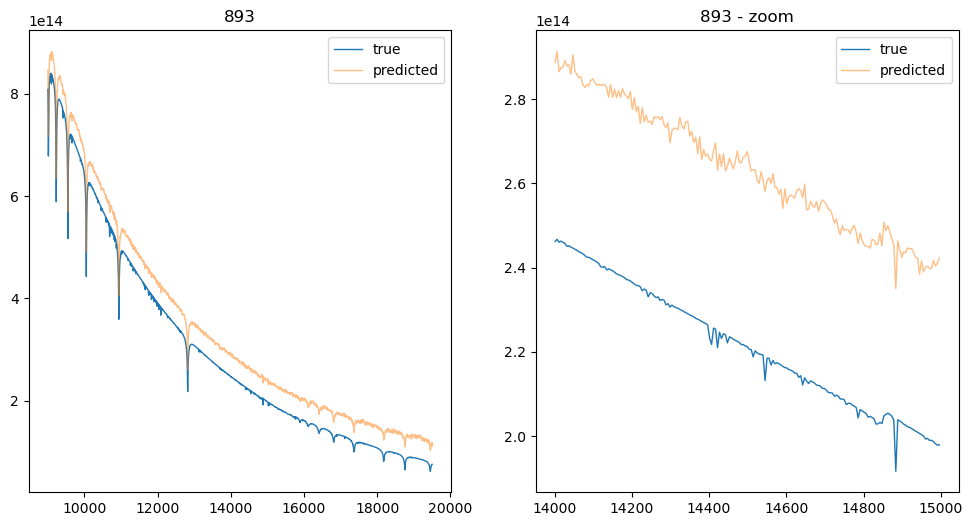

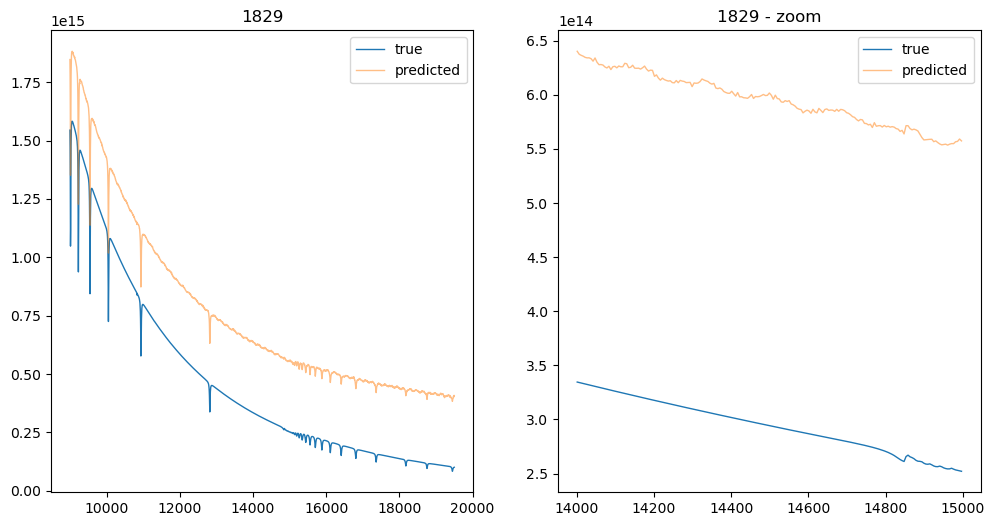

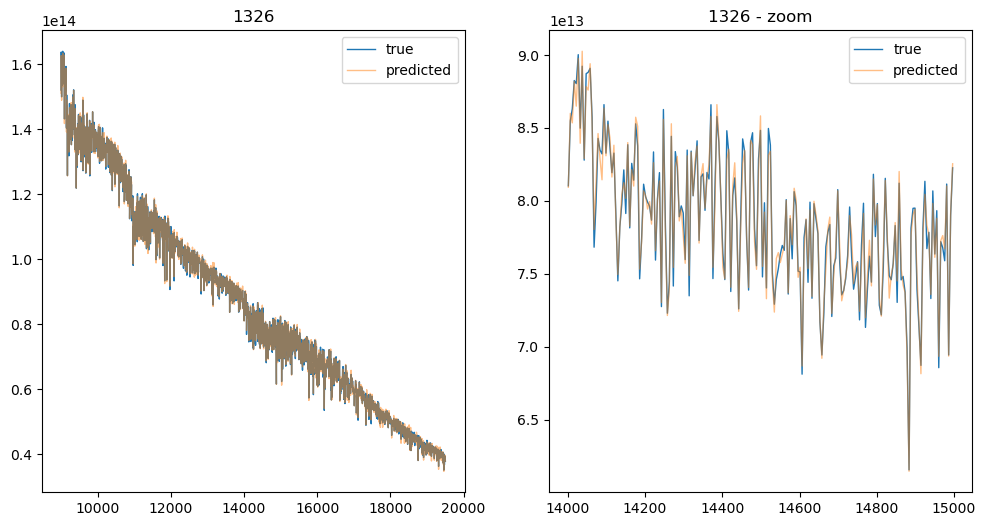

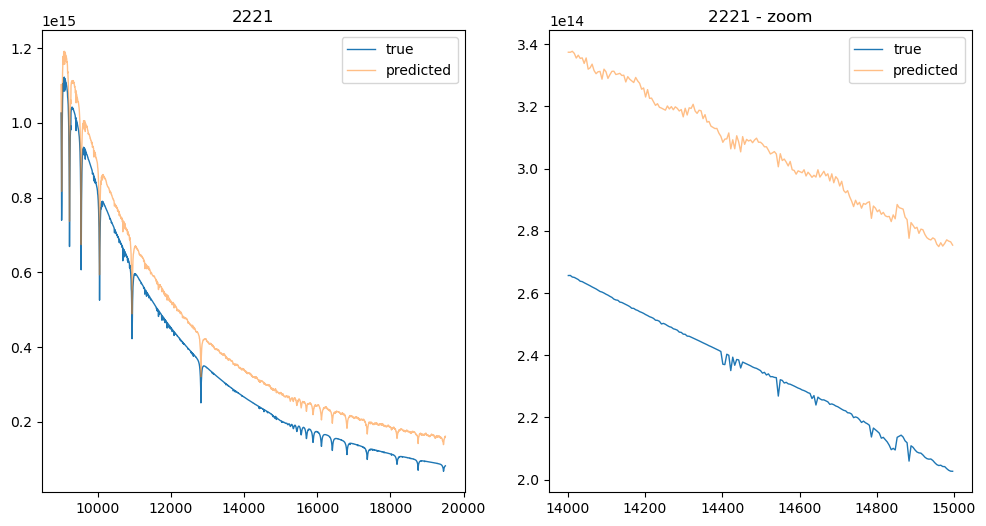

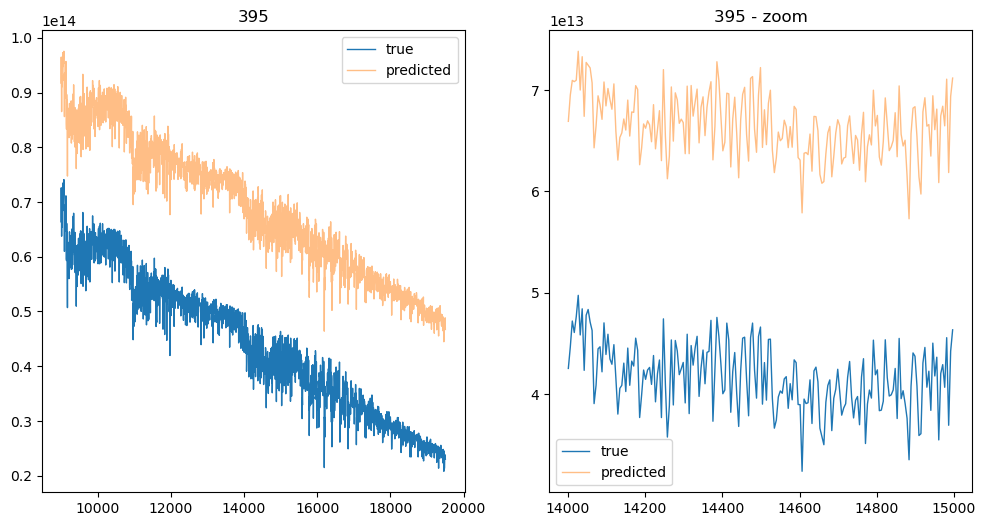

In [60]:
model = Autoencoder(fluxes.shape[-1], nneurons).to(device, tensor_dtype)

ds = TensorDataset(bbsimplescale.to(device, tensor_dtype), bbsimplescale.to(device, tensor_dtype), infeatures.to(device, tensor_dtype))

regloss = nn.MSELoss()
fourierloss = nn.MSELoss()
losspairs = []
def msefft_loss(pred, y, fftweight=.02):
    Fpred = torch.fft.fft(pred)
    Fy = torch.fft.fft(y)
    l1 = regloss(pred, y)
    l2 = fftweight*fourierloss(Fpred.abs(), Fy.abs()) # should really have some dynamic scaling here...
    losspairs.append((l1.item(), l2.item()))
    return (l1 + l2)/(1+fftweight)

nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=lr, 
                                            weight_decay=wd, 
                                            loss_fcn=msefft_loss, 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')

plt.figure()
plt.semilogy(losspairs)

plot_sample_specs(model, data_split)

def descaler(y, infeatures):
    bb = models.BlackBody(temperature=infeatures[0].item()*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    bbflux = (bb(wl << u.angstrom)*(np.pi*u.sr)).to(u.erg/u.s * u.cm**-3).value
    return (y + 1)*bbflux.mean() 
    
plot_sample_specs(model, data_split, descaler)

This isn't helping much, probably some normalization glitch.  Maybe not needed?